<a href="https://colab.research.google.com/github/rsuwa/self-driving-mini-car/blob/main/learn_steer_throttle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls /content/drive/MyDrive/train_data_D | wc -l

3499


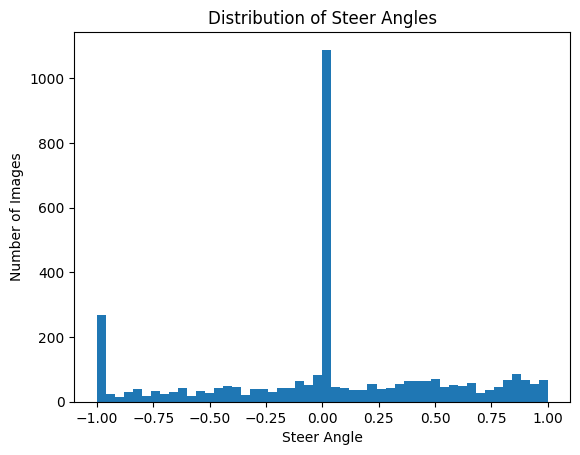

In [4]:
import os
import matplotlib.pyplot as plt

# フォルダのパスを設定
folder_path = "/content/drive/MyDrive/train_data_D"  # 例: "/path/to/your/folder"

# ステア角のリストを作成
steer_angles = []

# フォルダ内のすべてのファイルをループ
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):  # .jpgファイルのみを対象
        # ステア角を取得
        angle = filename.split("_")[0]
        try:
            steer_angles.append(float(angle))
        except ValueError:
            print(f"Could not convert {angle} to float from filename {filename}")
            continue

# ステア角の分布をヒストグラムとしてプロット
plt.hist(steer_angles, bins=50)
plt.title("Distribution of Steer Angles")
plt.xlabel("Steer Angle")
plt.ylabel("Number of Images")
plt.show()


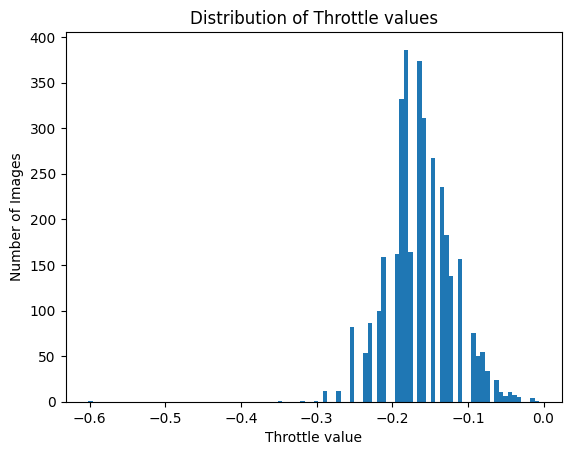

In [5]:
import os
import matplotlib.pyplot as plt

# フォルダのパスを設定
folder_path = "/content/drive/MyDrive/train_data_D"  # 例: "/path/to/your/folder"

# ステア角のリストを作成
throttles = []

# フォルダ内のすべてのファイルをループ
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):  # .jpgファイルのみを対象
        # throttle値を取得
        throttle = filename.split("_")[1]
        try:
            throttles.append(float(throttle))
        except ValueError:
            print(f"Could not convert {throttle} to float from filename {filename}")
            continue

# ステア角の分布をヒストグラムとしてプロット
plt.hist(throttles, bins=100)
plt.title("Distribution of Throttle values")
plt.xlabel("Throttle value")
plt.ylabel("Number of Images")
plt.show()


In [6]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np

# 無駄なファイル削除

In [7]:
import os

def delete_files(start, end, dir_path, file_extension=".jpg"):
    """
    Delete files in a numerical range with a specific extension.

    :param start: Start of the numerical range
    :param end: End of the numerical range
    :param dir_path: Path to the directory containing the files
    :param file_extension: Extension of the files to delete
    """
    for i in range(start, end + 1):
        # Generate filename
        filename = f"{i:04d}{file_extension}"
        file_path = os.path.join(dir_path, filename)

        # Try to delete the file, and pass if it doesn't exist
        try:
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            pass

# Example usage:
delete_files(0, 4000, "/content/drive/MyDrive/train_data_D")


File not found: /content/drive/MyDrive/train_data_D/0000.jpg
File not found: /content/drive/MyDrive/train_data_D/0001.jpg
File not found: /content/drive/MyDrive/train_data_D/0002.jpg
File not found: /content/drive/MyDrive/train_data_D/0003.jpg
File not found: /content/drive/MyDrive/train_data_D/0004.jpg
File not found: /content/drive/MyDrive/train_data_D/0005.jpg
File not found: /content/drive/MyDrive/train_data_D/0006.jpg
File not found: /content/drive/MyDrive/train_data_D/0007.jpg
File not found: /content/drive/MyDrive/train_data_D/0008.jpg
File not found: /content/drive/MyDrive/train_data_D/0009.jpg
File not found: /content/drive/MyDrive/train_data_D/0010.jpg
File not found: /content/drive/MyDrive/train_data_D/0011.jpg
File not found: /content/drive/MyDrive/train_data_D/0012.jpg
File not found: /content/drive/MyDrive/train_data_D/0013.jpg
File not found: /content/drive/MyDrive/train_data_D/0014.jpg
File not found: /content/drive/MyDrive/train_data_D/0015.jpg
File not found: /content

## スロットル値が0に近い画像を削除

In [21]:
import os

# フォルダのパスを設定
folder_path = "/content/drive/MyDrive/train_data_D"  # 例: "/path/to/your/folder"
throttle_threshold = 0.005 # スロットル値がこの値未満のファイルを削除
steer_angle_threshold = 0.05
cnt = 0
# フォルダ内のすべてのファイルをループ
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):  # .jpgファイルのみを対象
        # スロットル値を取得
        throttle_str = filename.split("_")[1]
        # ステア値を取得
        steer_angle_str = filename.split("_")[0]
        try:
            throttle = float(throttle_str)
            steer_angle = float(steer_angle_str)

            # スロットル値が指定された閾値未満かをチェック
            if abs(throttle) < throttle_threshold:
                # and abs(steer_angle) < steer_angle_threshold:
                file_path = os.path.join(folder_path, filename)
                os.remove(file_path)
                print(f"Removed {filename}, steer={steer_angle}, throttle={throttle}")
                cnt += 1
        except ValueError:
            print(f"Could not convert {throttle_str} to float from filename {filename}")
            continue
print(cnt)


Removed -1.000000_-0.000000_9b65a526-6100-11ee-b386-0242c6b6e9d9.jpg, steer=-1.0, throttle=-0.0
Removed -0.000000_-0.000000_163a9af0-6100-11ee-b386-0242c6b6e9d9.jpg, steer=-0.0, throttle=-0.0
Removed -0.000000_-0.000000_18d9605c-6100-11ee-b386-0242c6b6e9d9.jpg, steer=-0.0, throttle=-0.0
Removed 0.312671_-0.000000_94e0f458-6100-11ee-b386-0242c6b6e9d9.jpg, steer=0.312671, throttle=-0.0
Removed -0.000000_-0.000000_18fe8a08-6100-11ee-b386-0242c6b6e9d9.jpg, steer=-0.0, throttle=-0.0
Removed -0.000000_-0.000000_15fcd274-6100-11ee-b386-0242c6b6e9d9.jpg, steer=-0.0, throttle=-0.0
Removed -0.000000_-0.000000_17e299c0-6100-11ee-b386-0242c6b6e9d9.jpg, steer=-0.0, throttle=-0.0
Removed -0.000000_-0.000000_16f69200-6100-11ee-b386-0242c6b6e9d9.jpg, steer=-0.0, throttle=-0.0
Removed 1.000000_-0.000000_10d981ec-6101-11ee-b386-0242c6b6e9d9.jpg, steer=1.0, throttle=-0.0
Removed -0.000000_-0.000000_f0bbbca0-60ff-11ee-b386-0242c6b6e9d9.jpg, steer=-0.0, throttle=-0.0
Removed -0.000000_-0.000000_9c4ee8d0-61

In [8]:
def get_steering(path):
    """Gets the steering value from the image filename"""
    gets = path.split('_')
    return float(gets[0])

def get_speed(path):
    """Gets the speed value from the image filename"""
    gets = path.split('_')
    return float(gets[1])

class SSDataset(torch.utils.data.Dataset):

    def __init__(self, directory, random_hflips=False):
        self.directory = directory
        self.random_hflips = random_hflips
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        image = PIL.Image.open(image_path)
        x = float(get_steering(os.path.basename(image_path)))
        y = float(get_speed(os.path.basename(image_path)))

        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return image, torch.tensor([x, y]).float()

dataset = SSDataset('/content/drive/MyDrive/train_data_D', random_hflips=False)

In [9]:
test_percent = 0.1
num_test = int(test_percent * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - num_test, num_test])


In [10]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

# Frozen for modle layer1 to layer3
for l in model.layer1.parameters():
    l.requires_grad=False
for l in model.layer2.parameters():
    l.requires_grad=False
for l in model.layer3.parameters():
    l.requires_grad=False

In [13]:
EARLY_STOP = True


NUM_EPOCHS = 100
BEST_MODEL_PATH = 'best_steering_model_ResNet.pth'
best_loss = 1e9
optimizer = optim.Adam(model.parameters())

es_counter = 0
for epoch in range(NUM_EPOCHS):

    model.train()
    train_loss = 0.0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        loss.backward()
        train_loss += float(loss)
        optimizer.step()
    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)
    test_loss /= len(test_loader)
    print('%d, %f, %f' % (epoch, train_loss, test_loss))
    if test_loss < best_loss:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = test_loss
        es_counter=0
    else:
        if es_counter == 10 and EARLY_STOP:
            print("Early Stopping EPOCH[{}], val_loss {:4f}".format(epoch, best_loss))
            break
        else:
            es_counter += 1


0, 0.125280, 0.045017
1, 0.042612, 0.037582
2, 0.034136, 0.021841
3, 0.028921, 0.027342
4, 0.028003, 0.022124
5, 0.024422, 0.027622
6, 0.019928, 0.022876
7, 0.021287, 0.026520
8, 0.020090, 0.019482
9, 0.017177, 0.021721
10, 0.016019, 0.020972
11, 0.014514, 0.023128
12, 0.014463, 0.020536
13, 0.014720, 0.019565
14, 0.014543, 0.025720
15, 0.013765, 0.022621
16, 0.012727, 0.019496
17, 0.011910, 0.021998
18, 0.013260, 0.019389
19, 0.012339, 0.023363
20, 0.011547, 0.023279
21, 0.010727, 0.020309
22, 0.011603, 0.026978
23, 0.011516, 0.021834
24, 0.010699, 0.018142
25, 0.008896, 0.020781
26, 0.009063, 0.017464
27, 0.008782, 0.032209
28, 0.008621, 0.017939
29, 0.007866, 0.019344
30, 0.007579, 0.019569
31, 0.006735, 0.021452
32, 0.006850, 0.021502
33, 0.006935, 0.020389
34, 0.006548, 0.023096
35, 0.007227, 0.019668
36, 0.007705, 0.022153
37, 0.006645, 0.019912
Early Stopping EPOCH[37], val_loss 0.017464


In [36]:
TEST_DATA_IMAGE = '/content/drive/MyDrive/train_data_D/1.000000_-0.128851_00dd6bba-6100-11ee-b386-0242c6b6e9d9.jpg'

model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 2)
model.load_state_dict(torch.load('best_steering_model_ResNet.pth'))
model = model.to(device)
model = model.eval()
image_path = TEST_DATA_IMAGE
image = PIL.Image.open(image_path)
image = transforms.functional.resize(image, (224, 224))
image = transforms.functional.to_tensor(image)
image = image.numpy()[::-1].copy()
image = torch.from_numpy(image)
image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)
outputs = model(image[None, ...])
print(outputs)

tensor([[ 0.9458, -0.1166]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [37]:
image = PIL.Image.open(image_path)
image_orig_size = image.size

sample_image = transforms.functional.resize(image, (224, 224))


sample_image = transforms.functional.to_tensor(sample_image)
sample_image = sample_image.numpy()[::-1].copy()
sample_image = torch.from_numpy(sample_image)
sample_image = transforms.functional.normalize(sample_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

In [38]:
# https://tech.jxpress.net/entry/2018/12/12/130057
# https://jacobgil.github.io/deeplearning/vehicle-steering-angle-visualizations
class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 最終層逆伝播時の勾配を記録する
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録する
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self,output):
        self.model.zero_grad()
        output.backward()

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()


In [39]:
model.eval()
grad_cam = GradCAM(model=model, feature_layer=list(model.layer4.modules())[-1])

In [40]:
model_output = grad_cam.forward(sample_image[None, ...])
print(model_output)
#model_output.backward()
grad_cam.backward_on_target(model_output[0][0])

tensor([[ 0.9458, -0.1166]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [41]:
import numpy as np
# Get feature gradient
feature_grad = grad_cam.feature_grad.data.cpu().numpy()[0]
# Get weights from gradient
weights = np.mean(feature_grad, axis=(1, 2))  # Take averages for each gradient
# Get features outputs
feature_map = grad_cam.feature_map.data.cpu().numpy()
grad_cam.clear_hook()

In [42]:
# Get cam
cam = np.sum((weights * feature_map.T), axis=2).T
cam = np.maximum(cam, 0)  # apply ReLU to cam

In [43]:
print(cam)

[[0.01147817 0.01149226 0.00870594 0.00749103 0.00752727 0.00811946
  0.00857974]
 [0.0206753  0.02210051 0.0157478  0.01181127 0.00841201 0.00541163
  0.00606972]
 [0.02544965 0.02811323 0.01792392 0.0148327  0.01186248 0.01073851
  0.00758097]
 [0.02960677 0.03581473 0.0231582  0.01972902 0.01762768 0.01945228
  0.01514362]
 [0.02506732 0.02850546 0.02089337 0.01951485 0.02117041 0.02600546
  0.01903239]
 [0.01297603 0.01140941 0.01208313 0.02573464 0.05152241 0.0512275
  0.00311227]
 [0.0108698  0.00979579 0.00822116 0.0122036  0.02439857 0.01470079
  0.        ]]


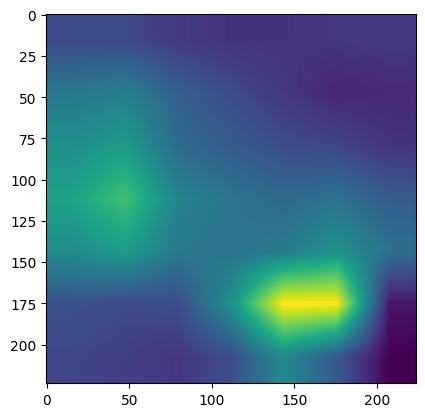

In [44]:
#(cam*10000).astype(np.uint8)
import cv2
import matplotlib.pyplot as plt
cam = cv2.resize(cam, (224,224))
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
plt.imshow(cam)
plt.show()

In [45]:
activation_heatmap = np.expand_dims(cam, axis=0).transpose(1,2,0)
org_img = np.asarray(image.resize((224,224)))
img_with_heatmap = np.multiply(np.float32(activation_heatmap), np.float32(org_img))
img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
org_img = cv2.resize(org_img, image_orig_size)

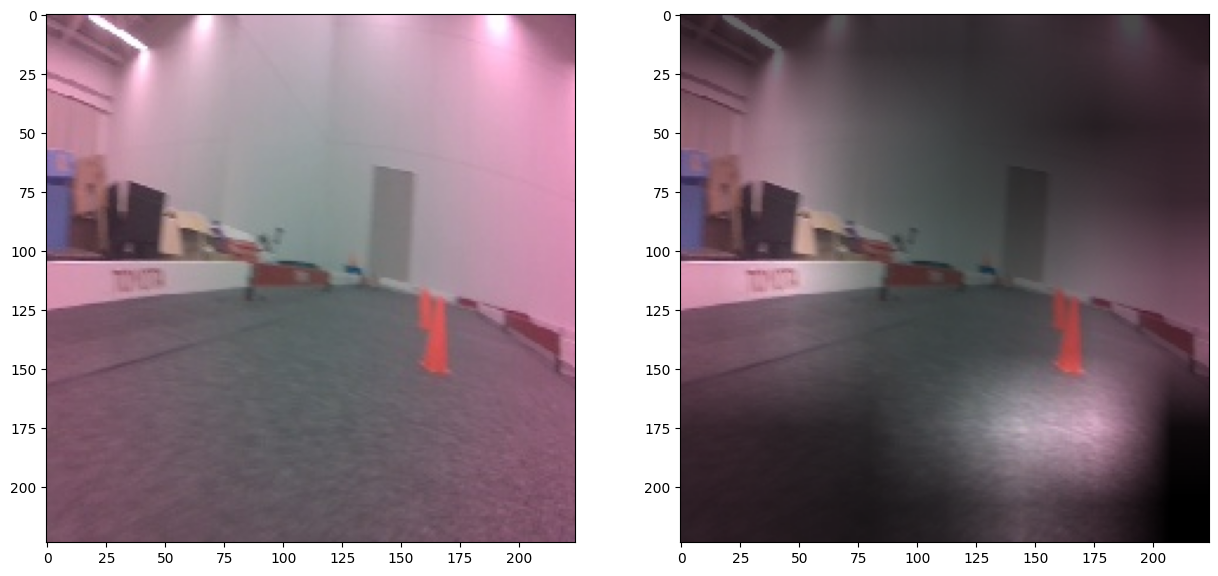

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(org_img)
plt.subplot(1,2,2)
plt.imshow(cv2.resize(np.uint8(255 * img_with_heatmap), image_orig_size))
plt.show()